In [1]:
import WNQuery
import os
import sys
from wnxmlconsole import write_synset
from pprint import pformat, pprint
import networkx as nx
import matplotlib.pyplot as plt
from operator import attrgetter, itemgetter
from itertools import chain
from collections import namedtuple
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
import numpy as np

In [2]:
wn = WNQuery.WNQuery("plwordnet-3.1-visdisc.xml", open(os.devnull, "w"))
wn.writeStats(sys.stderr)

PoS		#synsets	#word senses	#words
Nouns		132398		176779		134778
Verbs		27693		38564		19595
Adjectives	11256		14035		8006
Adverbs		0		0		0


## Wszystkie znaczenia słowa szkoda i ich synonimy

In [3]:
szkoda_synset = wn.lookUpLiteral('szkoda', 'n')
for x in szkoda_synset:
    id = x.wnid
    write_synset(x, sys.stdout)
    synonymIds = wn.lookUpRelation(id, 'n', 'bliskoznaczność')
    print("synonimy:")
    for y in synonymIds:
        write_synset(wn.lookUpID(y, 'n'), sys.stdout)
    print("---------\n")

PLWN-00003675-n  {strata:1, utrata:1, szkoda:2, uszczerbek:1}  ()
synonimy:
PLWN-00078375-n  {szwank:1, niekorzyść:1}  ()
---------

PLWN-00006533-n  {szkoda:1}  (brak danych)
synonimy:
---------



In [4]:
from itertools import tee, islice


def window(it, size=3):
    yield from zip(
        *[islice(it, s, None) for s, it in enumerate(tee(it, size))])

In [5]:
def synset_string(syns):
    buff = []
    for i in syns.synonyms:
        buff.append("{0}".format(i.literal))
    return "{{{0}}}  ({1})".format(", ".join(buff), syns.definition)

### Hiperonimia `wypadek drogowy`

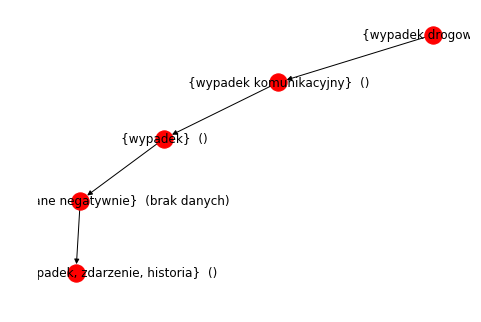

In [8]:
wypadek = wn.lookUpLiteral('wypadek drogowy', 'n')[0]
hypernym_ids = wn.traceRelationD(wypadek.wnid, 'n', 'hypernym')
nodes = map(lambda h: synset_string(wn.lookUpID(h[0], 'n')), hypernym_ids)
node_list = list(nodes)

G = nx.DiGraph()
edges = window(node_list, 2)
for e in edges:
    G.add_edge(e[0], e[1])
pos = nx.layout.spring_layout(G)
nx.draw(G, with_labels=True)

In [9]:
meanigs = map(lambda h: wn.lookUpID(h[0], 'n'), hypernym_ids)
list(meanigs)

In [10]:
wn.traceRelation('PLWN-00000323-n', 'n', 'hypernym')
wn.traceRelation('PLWN-00036467-n', 'n', 'hypernym')
wn.traceRelation('PLWN-00102819-n', 'n', 'hypernym')

['PLWN-00102819-n', 'PLWN-00027419-n', 'PLWN-00006526-n']

## Bezpośrednie hiponimy `wypadek_1`

In [11]:
wypadek1 = wn.lookUpLiteral('szkoda', 'n')[0].wnid
wypadek_hiponyms = wn.traceRelationD(wypadek1, 'n', 'hyponym')

for x in filter(lambda tup: tup[1] == 1, wypadek_hiponyms):
    synset = wn.lookUpID(x[0], 'n')
    write_synset(synset, sys.stdout)

PLWN-00001439-n  {krzywda:1, niesprawiedliwość:1}  (brak danych)
PLWN-00046769-n  {uszczerbek na zdrowiu:1}  ()
PLWN-00235767-n  {frycowe:1, gapowe:1}  ()
PLWN-00235773-n  {przegrana:2}  ()
PLWN-00239437-n  {depersonalizacja:1}  ()
PLWN-00393729-n  {zgar:1}  ()
PLWN-00404031-n  {dekulturacja:1}  ()
PLWN-00411013-n  {straty moralne:1}  ()
PLWN-00419137-n  {trójkąt Harbergera:1}  ()
PLWN-00472552-n  {szkoda majątkowa:1}  ()


## hiponimy 2 rzędu dla `wypadek_2`

In [12]:
for x in filter(lambda tup: tup[1] == 2, wypadek_hiponyms):
    synset = wn.lookUpID(x[0], 'n')
    write_synset(synset, sys.stdout)

PLWN-00011033-n  {represja:1, ucisk:1, prześladowanie:2, terror:1}  ()
PLWN-00013469-n  {nietolerancja:1, nietolerancyjność:1}  ()
PLWN-00013551-n  {wyzysk:1}  ()
PLWN-00018350-n  {nierówność:2}  ()
PLWN-07062071-n  {autodestrukcja:2, samodestrukcja:2, samozagłada:2, samozniszczenie:2, samounicestwienie:2}  ()


In [28]:
RelationLink = namedtuple('RelationLink', ['node_from', 'node_to', 'relation'])
relation_color = {'hiponimia': 'r', 'hyponym': 'r', 'hypernym': 'g'}

word_set1 = [('szkoda', 2), ('strata', 1), ('uszczerbek', 1),
             ('szkoda majątkowa', 1), ('uszczerbek na zdrowiu', 1),
             ('krzywda', 1), ('niesprawiedliwość', 1), ('nieszczęście', 2)]
word_set2 = [('wypadek', 1), ('wypadek komunikacyjny', 1), ('kolizja', 2),
             ('zderzenie', 2), ('kolizja drogowa', 1), ('bezkolizyjny', 2),
             ('katastrofa budowlana', 1), ('wypadek drogowy', 1)]


def relevant_relation_links(synset, synsets):
    synset_ids = list(map(attrgetter('wnid'), synsets))
    filtered_relations = filter(lambda tup: tup[0] in synset_ids, synset.ilrs)
    relation_links = map(lambda x: RelationLink(synset.wnid, *x),
                         filtered_relations)
    return list(relation_links)


def get_synset(word, sense_number):
    return wn.lookUpSense(word, sense_number, 'n')


def realtion_graph(words):
    synsets = list(
        filter(None.__ne__, map(lambda tup: get_synset(*tup), words)))
    edge_lists = map(lambda s: relevant_relation_links(s, synsets), synsets)
    edges = list(set(chain.from_iterable(edge_lists)))
    G = nx.DiGraph()
    for e in edges:
        G.add_edge(e.node_from, e.node_to, color=relation_color[e.relation])
    pos = nx.layout.spring_layout(G)
    return G, pos, synsets

In [29]:
def draw_network(graph, pos, synsets, ax):
    for n in graph:
        c = Circle(pos[n], radius=0.2)
        ax.add_patch(c)
        graph.node[n]['patch'] = c
        x, y = pos[n]
        ax.text(x, y, n)
    seen = {}
    for (u, v, d) in graph.edges(data='color', default='purple'):
        n1 = graph.node[u]['patch']
        n2 = graph.node[v]['patch']
        rad = 0.1
        if (u, v) in seen:
            rad = seen.get((u, v))
            rad = (rad + np.sign(rad) * 0.1) * -1
        alpha = 0.5
        e = FancyArrowPatch(
            n1.center,
            n2.center,
            patchA=n1,
            patchB=n2,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=%s' % rad,
            mutation_scale=10.0,
            lw=2,
            alpha=alpha,
            color=d)
        seen[(u, v)] = rad
        ax.add_patch(e)
    return synsets

In [50]:
def output(words):
    ax = plt.gca()
    legend = draw_network(*realtion_graph(words), ax)
    ax.autoscale()
    plt.axis('equal')
    plt.axis('off')
    return set(list(map(lambda s: (s.wnid, synset_string(s)), legend)))

### Grafy relacji semantycznych

{('PLWN-00001439-n', '{krzywda, niesprawiedliwość}  (brak danych)'),
 ('PLWN-00003675-n', '{strata, utrata, szkoda, uszczerbek}  ()'),
 ('PLWN-00005640-n', '{nieszczęście, niedola}  ()'),
 ('PLWN-00046769-n', '{uszczerbek na zdrowiu}  ()'),
 ('PLWN-00472552-n', '{szkoda majątkowa}  ()')}

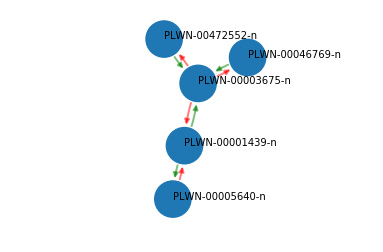

In [46]:
%matplotlib inline
output(word_set1)

{('PLWN-00001284-n', '{zderzenie, kraksa}  ()'),
 ('PLWN-00003982-n', '{wypadek}  ()'),
 ('PLWN-00006486-n', '{kolizja}  ()'),
 ('PLWN-00410901-n', '{wypadek komunikacyjny}  ()'),
 ('PLWN-00410902-n', '{wypadek drogowy}  ()'),
 ('PLWN-00411618-n', '{katastrofa budowlana}  ()'),
 ('PLWN-00441365-n', '{kolizja drogowa}  ()')}

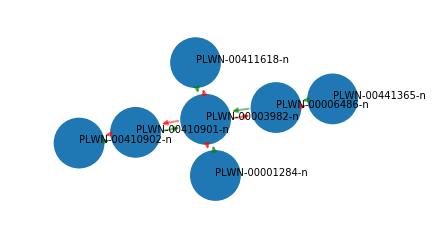

In [47]:
%matplotlib inline
output(word_set2)